In [2]:
import os
import shap
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
all_evaluation=glob.glob('../results/**/evaluation.csv', recursive=True)

In [4]:
evaluation_dicts={
    tuple(file.split(os.path.sep)[-4:-1]):pd.read_csv(file).T.rename(columns={
        0: 'RMSE',
        1: 'MBE',
        2: 'R2',
    }) 
    for file in all_evaluation
}

In [5]:
combined_evals=(
    pd.concat(list(evaluation_dicts.values()))
    .reset_index()
    .set_index(
        pd.MultiIndex.from_tuples(
            [
                (model, 'FullDataset', var)
                if land_cover == 'AllCombined'
                else (model, land_cover, var)
                for (model, land_cover, var) in [j for j in list(evaluation_dicts.keys()) for _ in range(2)]
            ]
        )
    )
)

combined_evals

index      RMSE           MBE  \
XGBoost    Vegetation   all           xgboost_train  0.006767  9.185928e-09   
                        all            xgboost_test  0.098444 -4.190954e-04   
                        baseline      xgboost_train  0.227302 -1.599045e-05   
                        baseline       xgboost_test  0.227505 -2.035415e-04   
                        uavsar        xgboost_train  0.014992  6.800677e-09   
                        uavsar         xgboost_test  0.102344  2.333223e-04   
           NoVegetation baseline      xgboost_train  0.237155 -2.760440e-06   
                        baseline       xgboost_test  0.238115  8.961712e-04   
                        uavsar        xgboost_train  0.012016  8.769661e-09   
                        uavsar         xgboost_test  0.093725  1.347675e-04   
           FullDataset  all           xgboost_train  0.008482  3.960739e-09   
                        all            xgboost_test  0.092769  1.963226e-04   
                        baseline      xgboost_train  0.248801 -1.755214e-06   
                        baseline       xgboost_test  0.248496  3.286213e-04   
                        uavsar        xgboost_train  0.013850  8.256242e-09   
                        uavsar         xgboost_test  0.097367  3.654146e-04   
ExtraTrees Vegetation   all       extra_trees_train  0.000267  0.000000e+00   
                        all        extra_trees_test  0.104882 -5.035757e-04   
                        baseline  extra_trees_train  0.135389 -5.927561e-18   
                        baseline   extra_trees_test  0.206534  3.374736e-04   
                        uavsar    extra_trees_train  0.000964  0.000000e+00   
                        uavsar     extra_trees_test  0.103928  4.113934e-05   
           NoVegetation baseline  extra_trees_train  0.191313 -1.842965e-17   
                        baseline   extra_trees_test  0.226129  1.200466e-03   
                        uavsar    extra_trees_train  0.001247  0.000000e+00   
                        uavsar     extra_trees_test  0.099829  1.569147e-04   
           FullDataset  all       extra_trees_train  0.000719  0.000000e+00   
                        all        extra_trees_test  0.099106  2.604292e-04   
                        baseline  extra_trees_train  0.199198  7.252473e-18   
                        baseline   extra_trees_test  0.236293  3.055893e-04   
                        uavsar    extra_trees_train  0.001215  0.000000e+00   
                        uavsar     extra_trees_test  0.101268  2.834051e-04   
NNets      Vegetation   all        pytorch_nn_train  0.149765 -8.733784e-04   
                        all         pytorch_nn_test  0.151534 -1.002038e-03   
                        baseline   pytorch_nn_train  0.228280  6.141112e-03   
                        baseline    pytorch_nn_test  0.227928  5.876385e-03   
                        uavsar     pytorch_nn_train  0.167844  3.693555e-03   
                        uavsar      pytorch_nn_test  0.168812  3.467992e-03   
           NoVegetation baseline   pytorch_nn_train  0.238513  1.468354e-03   
                        baseline    pytorch_nn_test  0.239185  2.382150e-03   
                        uavsar     pytorch_nn_train  0.157861  9.452646e-03   
                        uavsar      pytorch_nn_test  0.159623  9.676993e-03   
           FullDataset  all        pytorch_nn_train  0.154906 -9.469306e-03   
                        all         pytorch_nn_test  0.155443 -8.986168e-03   
                        baseline   pytorch_nn_train  0.250086  1.113311e-02   
                        baseline    pytorch_nn_test  0.249557  1.146438e-02   
                        uavsar     pytorch_nn_train  0.164909  9.347508e-03   
                        uavsar      pytorch_nn_test  0.165037  9.698529e-03   

                                        R2  
XGBoost    Vegetation   all       0.999340  
                        all       0.860150  
                        baseline  0.255

In [6]:
combined_evals=(
    combined_evals
    .reset_index()
    .rename(columns={
        'level_0': 'Model',
        'level_1': 'Data',
        'level_2': 'Features',
    })
)

training_evals=(
    combined_evals[
        combined_evals["index"].str.contains("train", case=False)
    ]
    .drop(columns="index")
)

testing_evals=(
    combined_evals[
        combined_evals["index"].str.contains("test", case=False)
    ]
    .drop(columns="index")
)
testing_evals=testing_evals.replace({
    'Vegetation': 'Vegetated Areas',
    'NoVegetation': 'Open Areas',
    'FullDataset': 'Full Dataset',
    'NNets': "FNN",
    'ExtraTrees': 'Extra Trees',
    'all': 'InSAR + \n Vegetation Height',
    'baseline': 'Elevation',
    'uavsar': 'InSAR'
})

training_evals=training_evals.replace({
    'Vegetation': 'Vegetated Areas',
    'NoVegetation': 'Open Areas',
    'FullDataset': 'Full Dataset',
    'NNets': "FNN",
    'ExtraTrees': 'Extra Trees',
    'all': 'InSAR + \n Vegetation Height',
    'baseline': 'Elevation',
    'uavsar': 'InSAR'
})

testing_evals.round(4).to_csv("../results/testing_evaluation_comparison.csv")
training_evals.round(4).to_csv("../results/training_evaluation_comparison.csv")

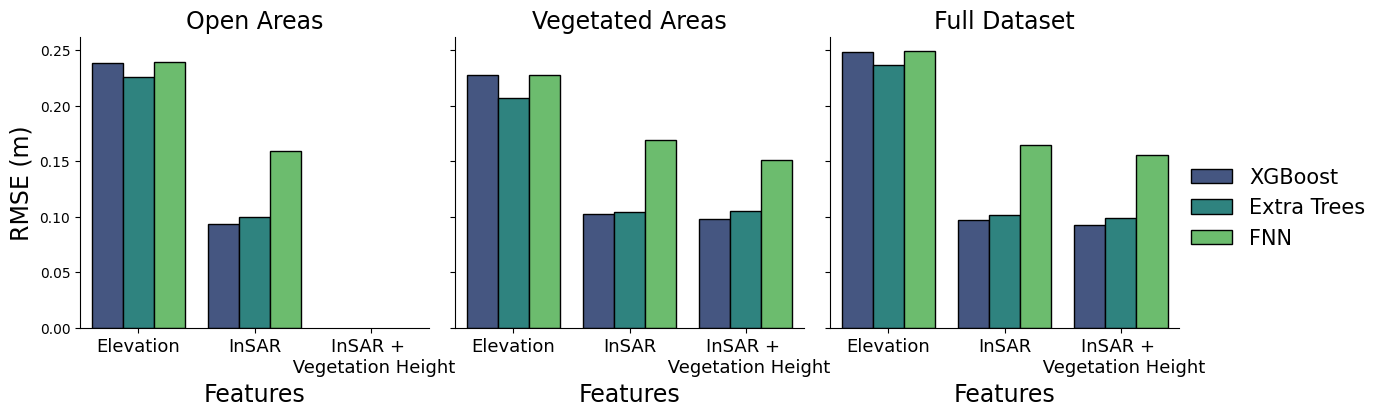

In [22]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Full Dataset'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="RMSE", 
    hue="Model", 
    palette="viridis", 
    edgecolor='black', 
    order=['Elevation', 'InSAR', 'InSAR + \n Vegetation Height']
)
g.set_axis_labels("Features", "RMSE (m)", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

plt.savefig('../plots/rmse_comparison.png', dpi=300)
plt.show()

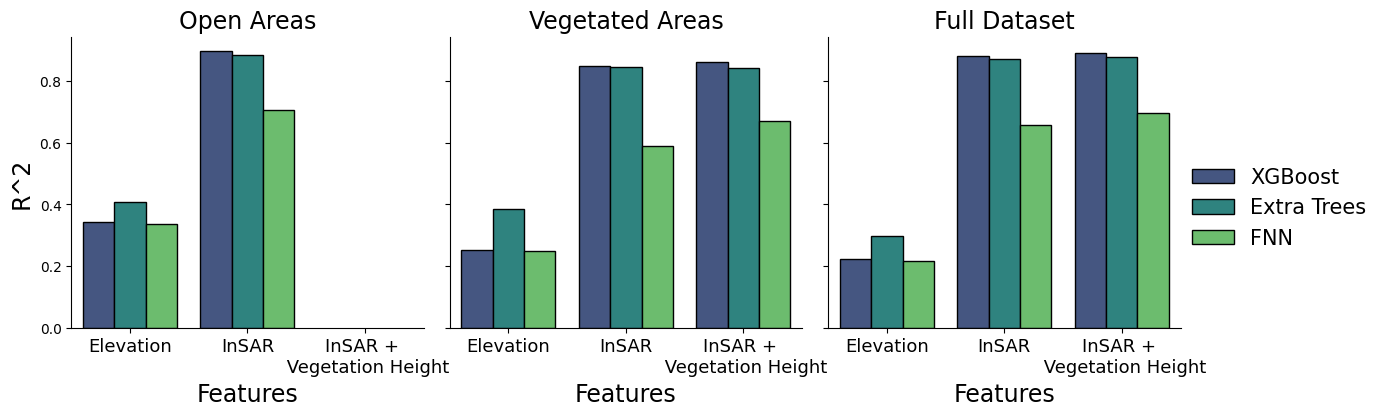

In [16]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Full Dataset'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="R2", 
    hue="Model", 
    palette="viridis", 
    edgecolor='black', 
    order=['Elevation', 'InSAR', 'InSAR + \n Vegetation Height']
)
g.set_axis_labels("Features", "R^2", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

plt.savefig('../plots/r2_comparison.png', dpi=300)
plt.show()

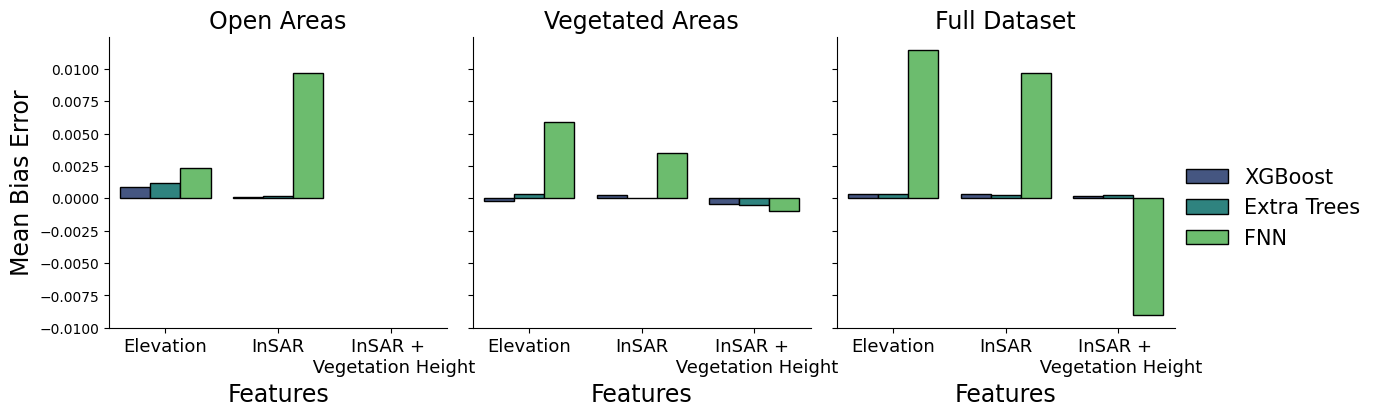

In [18]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Full Dataset'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="MBE", 
    hue="Model", 
    palette="viridis", 
    edgecolor='black', 
    order=['Elevation', 'InSAR', 'InSAR + \n Vegetation Height']
)
g.set_axis_labels("Features", "Mean Bias Error", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

plt.savefig('../plots/mbe_comparison.png', dpi=300)
plt.show()

## Feature Importance

* Impurity-based Importance

In [23]:
xgboost_all=pd.read_csv('../results/XGBoost/AllCombined/all/feature_importances.csv')
xgboost_all=xgboost_all.sort_values(by='importance', ascending=True)
xgboost_all

,feature,importance
6,wrapped_phase,0.012034
5,coherence,0.012586
4,vegetation_ht,0.022043
3,incidence_angle,0.027614
2,amplitude,0.031821
1,bare_earth_dem,0.037140
0,unwrapped_phase,0.068860


* Shap Importance

In [24]:
with open('../results/shap_values.pkl', 'rb') as f:
    overall_shap = pickle.load(f)

with open('../data/full_splits.pkl', 'rb') as f:
    full_splits = pickle.load(f)

features=[
    'amplitude','unwrapped_phase',
    'coherence', 'incidence_angle',
    'bare_earth_dem', 'wrapped_phase', 'vegetation_ht'
]

shap_imp=pd.DataFrame(
    data={
        'feature': features,
        'importance': np.abs(overall_shap.values).mean(axis=0)
    }
)

shap_imp=shap_imp.sort_values(by='importance', ascending=True)
shap_imp

,feature,importance
2,coherence,0.017929
5,wrapped_phase,0.025693
6,vegetation_ht,0.034987
3,incidence_angle,0.054912
0,amplitude,0.056945
4,bare_earth_dem,0.082283
1,unwrapped_phase,0.084743


In [25]:
shap.summary_plot(overall_shap, full_splits['X_test'][features], feature_names=full_splits['X_test'][features].columns, show=False)
plt.savefig('../plots/shap_plot.png', dpi=300, bbox_inches='tight')
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


* Comparison plot

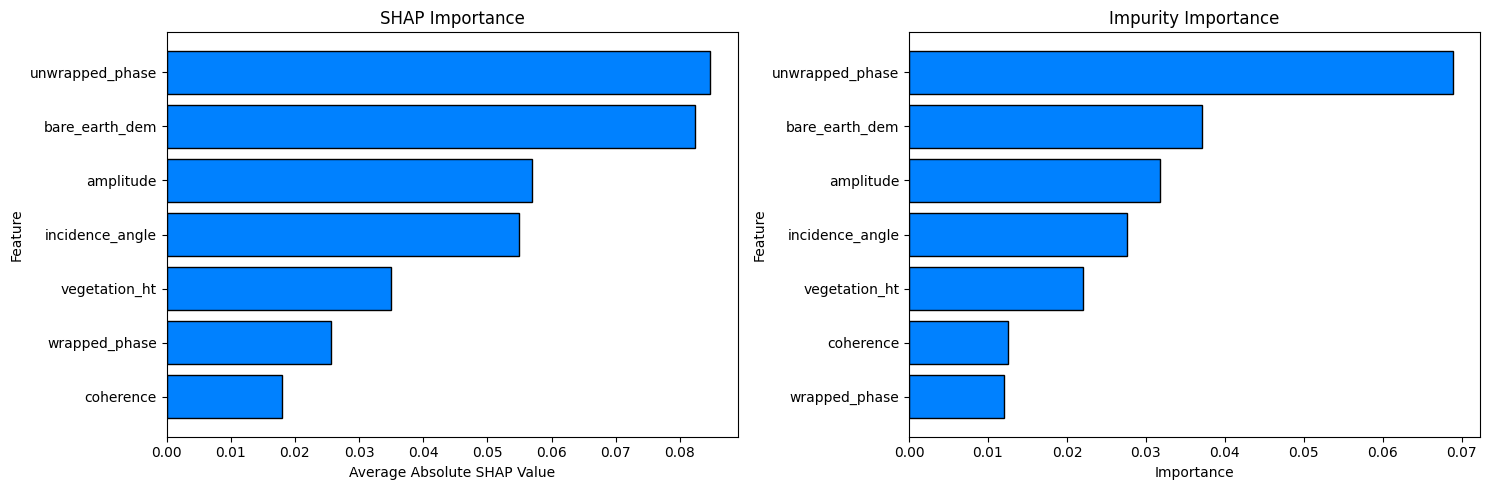

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.barh(
    y=shap_imp['feature'],
    width=shap_imp['importance'],
    color='#0081ff',
    edgecolor='k'
)
plt.xlabel('Average Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('SHAP Importance')


plt.subplot(1, 2, 2)
plt.barh(
    y=xgboost_all['feature'],
    width=xgboost_all['importance'],
    color='#0081ff',
    edgecolor='k'
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Impurity Importance')

plt.tight_layout()
#plt.savefig('../plots/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()